# Feature Importance, Model Explainability and XAI


* An __interpretable model__ is one whose decisions humans can understand.
* Some models such as linear models with a small number of variables, or decision trees with limited depth, are __intrinsically interpretable__. 
* Others such as ensembles, high-dimensional support vector machines or neural networks are essentially __black boxes__. 
* Interpretable ML studies how to make black box models comprehensible to humans, typically by showing how a few key features influence the machine prediction.
* Interpretable ML can be _local_ and tell us something about how a machine makes a prediction for a particular instance, or _global_. 
* Recently, there has been much interest in _model-agnostic_ interpretable ML that can provide interpretation for multiple ML families (e.g. trees, support vector machines and neural nets).

Reference:

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)



## Install and load packages

In [64]:
#!pip install shap

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor

import shap

## Prepare dataset

In [89]:
data_url = 'https://raw.githubusercontent.com/ShuklaPrashant21/Used-Car-Price-Prediction/master/car%20data.csv'
year = 2023

In [93]:
data = pd.read_csv(data_url, usecols=['Year','Selling_Price','Present_Price','Kms_Driven','Fuel_Type','Seller_Type','Transmission'])
data = data[data.Fuel_Type == "Petrol"]
data['Age'] = 2023 - data.Year
data = data.drop(columns=["Fuel_Type","Year"])

seller_type_map = {'Dealer': 0, 'Individual': 1}
transmission_map = {'Manual': 0, 'Automatic': 1}

data['Seller_Type'] = data['Seller_Type'].map(seller_type_map)
data['Transmission'] = data['Transmission'].map(transmission_map)

#lach_2_usd = 18945.85
#data["Selling_Price"] *= lach_2_usd

In [94]:
data.head()

,Selling_Price,Present_Price,Kms_Driven,Seller_Type,Transmission,Age
0,3.35,5.59,27000,0,0,9
2,7.25,9.85,6900,0,0,6
3,2.85,4.15,5200,0,0,12
6,6.75,8.12,18796,0,0,8
10,2.85,3.60,2135,0,0,6


In [105]:
X = data.drop(columns=['Selling_Price'])
y = data.Selling_Price

In [106]:
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, random_state=123)
Xtrn.shape, ytrn.shape, Xtst.shape, ytst.shape

((179, 5), (179,), (60, 5), (60,))

In [107]:
scaler = StandardScaler()
Xtrn = scaler.fit_transform(Xtrn)
Xtst = scaler.transform(Xtst)

## Interpretable models

### Linear Regression

In [176]:
feature_names = list(X.columns)
reg_feature_names = feature_names.copy()
reg_feature_names.insert(0,"const")

In [177]:
lr = LinearRegression()
lr.fit(Xtrn, ytrn)
list(zip(feature_names, lr.coef_))

[('Present_Price', 2.212101127581074),
 ('Kms_Driven', -0.12383850371433337),
 ('Seller_Type', -0.7057789726597506),
 ('Transmission', 0.03617906443603259),
 ('Age', -1.0177355143595084)]

In [178]:
import statsmodels.api

In [180]:
lr2 = sm.OLS(ytrn, sm.add_constant(Xtrn)).fit()
print(lr2.summary(xname=reg_feature_names))

                            OLS Regression Results                            
Dep. Variable:          Selling_Price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     161.1
Date:                Sat, 20 May 2023   Prob (F-statistic):           3.72e-63
Time:                        01:21:11   Log-Likelihood:                -306.42
No. Observations:                 179   AIC:                             624.8
Df Residuals:                     173   BIC:                             644.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2116      0.102     31.517

### Decision Trees

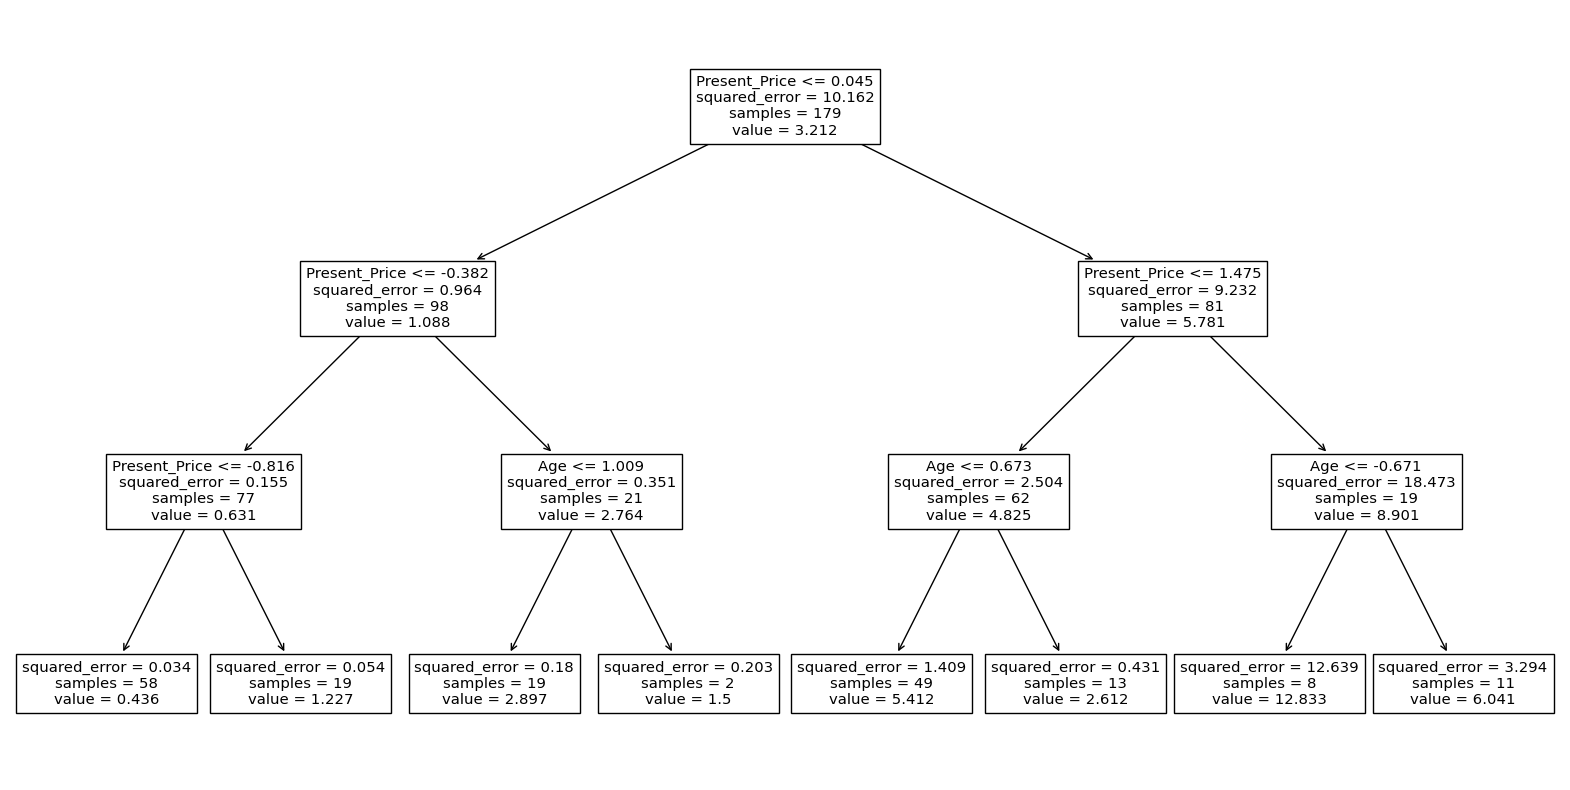

In [181]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(Xtrn, ytrn)
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns)
plt.show()

## An example of black box model: XGBoost

In [182]:
xgb = XGBRegressor()
xgb.fit(Xtrn, ytrn)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Surrogate model

In [191]:
surrogate_lr = sm.OLS(xgb.predict(Xtst), sm.add_constant(Xtst)).fit()
print(surrogate_lr.summary(xname=reg_feature_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     49.72
Date:                Sat, 20 May 2023   Prob (F-statistic):           5.27e-19
Time:                        01:24:18   Log-Likelihood:                -93.776
No. Observations:                  60   AIC:                             199.6
Df Residuals:                      54   BIC:                             212.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0407      0.160     19.046

## Permutation importance

In [192]:
from sklearn.inspection import permutation_importance

In [193]:
pi =permutation_importance(xgb, Xtst, ytst)
pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [194]:
(pd.
 DataFrame(pi.importances_mean, index=X.columns, columns=["permutation_importance"]).
 sort_values("permutation_importance", ascending=False)
)

,permutation_importance
Present_Price,2.140913
Age,0.318594
Kms_Driven,0.112321
Transmission,0.004579
Seller_Type,0.000026


## SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


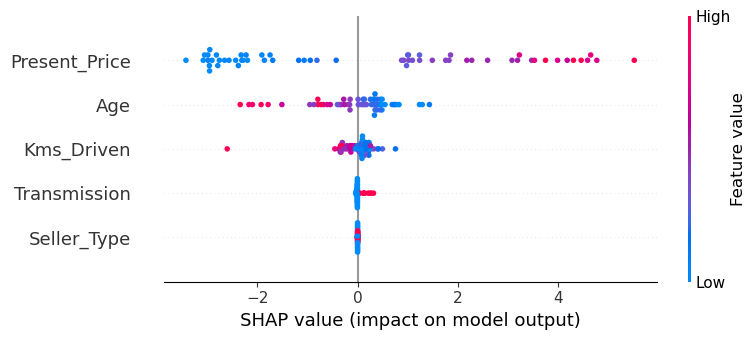

In [195]:
yhat = xgb.predict(Xtst)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(Xtst)
shap.summary_plot(shap_values, Xtst, feature_names=X.columns)

In [198]:
# load JS visualization code to notebook
shap.initjs()

In [205]:
# visualize the (i+1)-th prediction's explaination with default colors
i = 10
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])